# USRP B210 Control Script with UHD 
This notebook is designed to interface with the B210 via the UHD ddriver Python API and coordinate send and receive commands with chrip waveforms.

<u>McGill University Radio Lab</u>\
**File:** Updated_Loopback.ipynb\
**Authors:** Francis McGee, Michael Hétu\
**Date:** Feb 2024


## Import statements

In [1]:
from datetime import datetime, timedelta
from enum import Enum
import sys
import time
import threading
import numpy as np
import uhd
from uhd import libpyuhd as lib
import matplotlib.pyplot as plt

## Function Definitions

In [2]:
class States(Enum):
    """Enumerations to represent different states."""
    TUNE_CENTER_FREQ = 1
    RX_AND_SAVE_DATA = 2
    DONE = 3

class StateManager:
    """Class to manage state transitions."""
    def __init__(self):
        self.state = States.TUNE_CENTER_FREQ

    def set_state(self, state):
        self.state = state

    def get_state(self):
        return self.state

state_manager = StateManager()     
        
def tune_center_freq(usrp, current_freq, channel_list, tx_gain, tx_gain2, rx_gaina, rx_gainb):
    """Tune the center frequency and set the appropriate gain."""
    # Tune the center frequencies
    usrp.set_rx_freq(lib.types.tune_request(current_freq), 0)
    usrp.set_rx_freq(lib.types.tune_request(current_freq), 1)
    usrp.set_tx_freq(lib.types.tune_request(current_freq), 0)
    usrp.set_tx_freq(lib.types.tune_request(current_freq), 1)
    #Set gain values
    usrp.set_tx_gain(tx_gain, channel_list[0])
    usrp.set_rx_gain(rx_gaina, channel_list[0])
    usrp.set_rx_gain(rx_gainb, channel_list[1])

    # Wait for the local oscillators to lock
    while not(
        usrp.get_rx_sensor("lo_locked", 0).to_bool()
        and usrp.get_tx_sensor("lo_locked", 0).to_bool() #Maybe also wait for channel 1?
        ):
        pass
    state_manager.set_state(States.RX_AND_SAVE_DATA)
    return

def rx_worker(current_freq, num_samps, rx_streamer, rx_buffer_list, rx_buffer_list_ch2, wait_time):
        
    num_channels = rx_streamer.get_num_channels()
    num_rx_samps =0
    received_samples = []
    received_samples_ch2 = []

    recv_buffer = np.empty((num_channels, num_samps), dtype=np.complex64)

    # Craft and send the Stream Command
    rx_md = lib.types.rx_metadata()
    stream_cmd = lib.types.stream_cmd(lib.types.stream_mode.num_done)
    stream_cmd.num_samps = num_samps
    stream_cmd.stream_now = False
    stream_cmd.time_spec = wait_time

    rx_streamer.issue_stream_cmd(stream_cmd)

    rx = rx_streamer.recv(recv_buffer, rx_md)
    received_samples.extend(recv_buffer[0].tolist())
    received_samples_ch2.extend(recv_buffer[1].tolist())

    paired_samples = [(sample, current_freq) for sample in received_samples]
    paired_samples_ch2 = [(sample, current_freq) for sample in received_samples_ch2]
    
    rx_buffer_list.extend(paired_samples)
    rx_buffer_list_ch2.extend(paired_samples_ch2)

    state_manager.set_state(States.TUNE_CENTER_FREQ)

    return

def tx_worker(tx_streamer, tx_data, tx_md, wait_time):

    #Synchronize time and send data
    tx_md.time_spec = wait_time
    print(len(tx_data[0]), tx_streamer.send(tx_data, tx_md))

    return


def generate_tx_data(samp_rate, chirp_len, chirp_bandwidth):
    channel_list = (0,1)
    #generate chirps
    fs = samp_rate
    N2 = chirp_len
    bw = chirp_bandwidth
    n= np.arange(0, N2-1)
    t = n/fs 

    #send_chirp = np.array(np.sin(np.pi*.5*(bw/t[-1])*(t**2)), dtype = np.complex64)
    send_chirp = np.array(np.exp(1j*np.pi*.5*(bw/t[-1])*(t**2)), dtype = np.complex64)

    N = 4096 #PADDING number
    send_chirp = np.pad(send_chirp, (N), 'constant', constant_values=(0))
    wave_ampl = 0.8

    #tile the data because two channels
    tx_data = np.tile(send_chirp, (1,1)) #tiles to send one period
    tx_data = np.tile(tx_data[0], (len(channel_list),1)) 

    #create metadata for tx
    tx_md = lib.types.tx_metadata()
    tx_md.start_of_burst = True
    tx_md.end_of_burst = True
    tx_md.has_time_spec = True

    chirp_len = send_chirp.size
    chirp_duration = chirp_len / samp_rate

    return tx_data, tx_md, send_chirp, chirp_len
 

## Main

In [5]:
# Chirp parameters
CHIRP_LEN = 80000
CHIRP_BANDWIDTH = 10e6
current_freq = 400e6
end_freq = 1000e6
step_freq = CHIRP_BANDWIDTH

samp_rate = 20e6
current_channels = [0,1]
INIT_DELAY = 0.01

#Setting up USRP device
usrp = uhd.usrp.MultiUSRP("type = b200, num_recv_frames=800, num_send_frames=500")
usrp.set_clock_source("internal")


#Setting sample rates
usrp.set_tx_rate(samp_rate)
usrp.set_rx_rate(samp_rate)

#Setting stream arguments
st_args = uhd.usrp.StreamArgs("fc32", "sc16")
st_args.channels = [0,1]
rx_streamer = usrp.get_rx_stream(st_args)
tx_streamer = usrp.get_tx_stream(st_args)

#Initializing buffers
rx_buffer_list = []
rx_buffer_list_ch2 = []

#Creatin chirp tx data
tx_data, tx_md, send_chirp, chirp_len = generate_tx_data(samp_rate, CHIRP_LEN, CHIRP_BANDWIDTH)

#Defining the number of sample
num_samps = chirp_len

#Priming board for 
usrp.set_time_now(lib.types.time_spec(0,0))
tune_center_freq(usrp, current_freq, current_channels, 50,30,10,10)

#Main loop
while True:
    if (state_manager.get_state() == States.TUNE_CENTER_FREQ):

        tune_center_freq(usrp, current_freq, current_channels, 50,30,10,10)
        current_freq += step_freq
        
        if current_freq >= end_freq:
            state_manager.set_state(States.DONE)
            
    elif (state_manager.get_state() == States.RX_AND_SAVE_DATA):

        usrp.clear_command_time()

        wait_time = usrp.get_time_now() + lib.types.time_spec(INIT_DELAY)
        
        rx_thread = threading.Thread(target=rx_worker, args=(current_freq, num_samps, rx_streamer, rx_buffer_list, rx_buffer_list_ch2, wait_time))
        tx_thread = threading.Thread(target=tx_worker, args=(tx_streamer, tx_data, tx_md, wait_time))
  
        rx_thread.start()
        tx_thread.start()

        rx_thread.join()
        tx_thread.join()

        usrp.clear_command_time()

        
    elif(state_manager.get_state() == States.DONE):
        print("done")
        
        break

np.save("ch1_400_1000_loopback2_270cm.npy", rx_buffer_list)
np.save("ch2_400_1000_loopback2_270cm.npy", rx_buffer_list_ch2)

88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
88191 88191
done


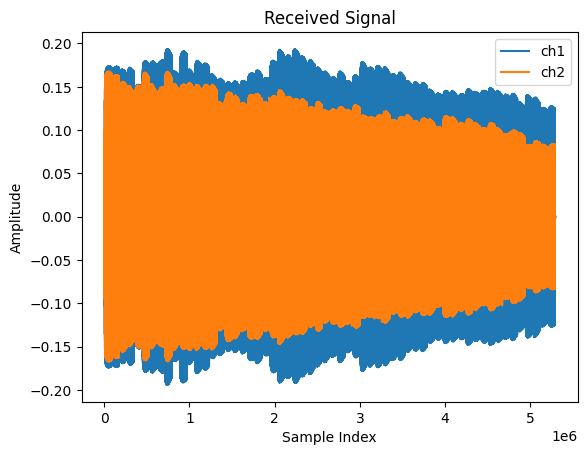

[ERROR] [UHD] An unexpected exception was caught in a task loop.The task loop will now exit, things may not work.EnvironmentError: IOError: usb rx8 transfer status: LIBUSB_TRANSFER_NO_DEVICE


In [6]:
    plt.figure()
    plt.plot(list(datum[0] for datum in rx_buffer_list), label="ch1")
    plt.plot(list(datum[0] for datum in rx_buffer_list_ch2), label="ch2") 
    plt.title('Received Signal')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    #plt.ylim([-1, 1])
    plt.legend()
    plt.savefig("400-1000-loopback2-270cm.png")
    plt.show()

In [ ]:
LOs = np.unique([datum[1] for datum in rx_buffer_list])
nsp = len(LOs)

f, ax = plt.subplots(1, 2, figsize = (15,5))

ax[0].plot(list(datum[0] for datum in rx_buffer_list), label="ch1")
ax[0].plot(list(datum[0] for datum in rx_buffer_list_ch2), label="ch2") 

for i in range (nsp):
    
    rx1 = [datum[0] for datum in rx_buffer_list if datum[1] == LOs[i]][:chirp_len]
    rx2 = [datum[0] for datum in rx_buffer_list_ch2 if datum[1] == LOs[i]][:chirp_len]

    ax[1].psd(rx1, Fs = samp_rate, Fc = LOs[i])
    ax[1].psd(rx2, Fs = samp_rate, Fc = LOs[i])

#ax[1].set_xlim(400000000,500000000)

plt.show()